In [109]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd  
import datetime as dt  



In [84]:
# Reflect Tables into SQLAlchemy ORM
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy import Column, Integer, String, Float


In [85]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [86]:
Base.metadata.create_all(engine)

In [87]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [88]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [89]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [90]:
inspector.get_table_names()

['measurement', 'station']

In [91]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [92]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [97]:
# Exploratory Climate Analysis
 # Design a query to retrieve the last 12 months of precipitation data and plot the results
precip_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the first element of the tuple
precip_data = precip_data[0]

# Calculate the date 1 year ago from the last data point in the database
aYear_ago = dt.datetime.strptime(precip_data, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= aYear_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y-%m-%d')

# Set index to date
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date', ascending=True)

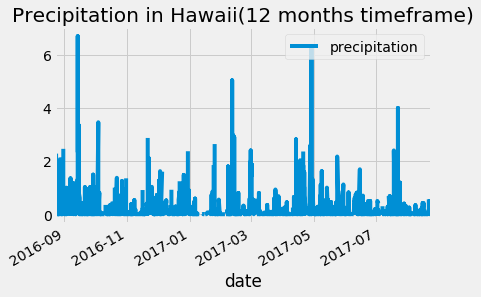

In [98]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df .plot(title="Precipitation in Hawaii(12 months timeframe)")
plt.legend(loc='upper right')
plt.savefig("precip_df.png")
plt.show()

In [99]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [100]:
# How many available stations are there in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {available_stations} ")

Stations Available: 9 


In [101]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)
     ).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations


Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [102]:
# Find the most active station
most_active_station=active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [107]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Temperature Values for most active station")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

Temperature Values for most active station
Low: 54.0 High: 85.0 Average: 71.7


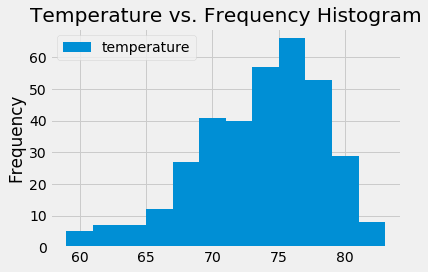

In [112]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count
    (Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station = most_temps_station[0]

# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= aYear_ago).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])

# We need 12 bins since the observation is for twelve months
temperature_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.tight_layout()
plt.savefig("Temperature_vs_Frequency.png")
plt.show()